# Projet 3 : Clustering et Analyses

In [1]:
%load_ext pep8magic

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
from random import sample
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Imputer
from scipy import stats
from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import (manifold, datasets, decomposition,
                     ensemble, discriminant_analysis, random_projection)

%matplotlib inline

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize': (11, 7)})
sns.set(rc={'font.size': 24})
# Paramètre de transparence
alpha = 0.5

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/03 - Projet 3/Main project")

In [3]:
def DistriPlot(Var, X):
    "Fonction permettant d'afficher la distribution statistique d'une variable (courbe + histogramme)"

    sns.distplot(Var)
    plt.xlabel(X, fontsize=18)
    plt.ylabel("Distribution", fontsize=18)
    plt.title("Distribution de " + X, fontsize=24)
    print("La médiane de ", X, "est de ", Var.median())
    print("La moyenne de ", X, "est de ", Var.mean())


def BoxPlot1D(X, title):
    "Fonction permettant d'afficher la distribution statistique d'une variable en boite à moustache"

    sns.boxplot(X)
    plt.title(title, fontsize=24)
    print(X.describe())


def Cluster_Count(labels):
    "Fonction qui permet d'afficher le nombre de cluster et le nombre d'individus par cluster"

    Count = []
    Nb_cluster = labels.max() + 1
    print('Il y a ', Nb_cluster, ' clusters différents')

    Count = np.bincount(labels)
    # barplot
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(121)
    sns.barplot(x=np.arange(1, Nb_cluster + 1),
                y=Count, ax=ax, palette='Dark2')
    # pour la couleur on peut pensé à : color=np.arange(Nb_cluster) 
    plt.title('Visualisation du nombre de cluster et de leur volume', fontsize=18)

    # pie chart
    ax = fig.add_subplot(122)
    ax.pie(Count, labels=np.arange(1, Nb_cluster + 1),
           autopct='%1.1f%%')
    plt.title('Répartition du nombre de points au sein des clusters', fontsize=18)

    plt.show()

### Import des différents data set d'analyse

In [4]:
data = pd.read_csv("data_clean.csv")
#data = data.drop('Unnamed: 0',axis=1)
print(data.columns)
# data.shape

Index(['CustomerID', 'frequency', 'monetary_value', 'Mean Quantity',
       'Mean UnitPrice'],
      dtype='object')


In [5]:
RFM = pd.read_csv("RFM.csv")
RFM.columns

Index(['CustomerID', 'recency', 'frequency', 'monetary_value', 'RFMScore'], dtype='object')

In [6]:
segm_rfm = pd.read_csv('segm_rfm.csv')
segm_rfm.head(6)

CustomerID  recency   frequency  monetary_value  r_quartile  f_quartile  \
0     12346.0     11.8    0.084746     6540.983051           4           4   
1     12347.0      1.1  165.454545     3918.181818           1           1   
2     12348.0      3.5    8.857143      513.497143           3           3   
3     12349.0      1.6   45.625000     1098.468750           1           2   
4     12350.0     11.3    1.504425       29.592920           4           4   
5     12352.0      2.2   38.636364     1139.109091           2           2   

   m_quartile  RFMScore  
0           1       441  
1           1       111  
2           2       332  
3           1       121  
4           4       444  
5           1       221

# Analyse des clusters obtenus par le score quantiles RFM 

Une classification possible est déjà de regrouper les clients selon leur score RFM 

In [7]:
RFM['RFMScore'].nunique()

55

In [8]:
#Cluster_Count(segm_rfm['RFMScore'])

### Etude des meilleurs clients (groupe 111)

In [9]:
print(RFM[RFM['RFMScore']==111].sort_values(
    'monetary_value', ascending=False).nunique())

RFM[RFM['RFMScore']==111].sort_values(
    'monetary_value', ascending=False).head(10)

CustomerID        645
recency            18
frequency         349
monetary_value    645
RFMScore            1
dtype: int64


CustomerID  recency  frequency  monetary_value  RFMScore
1689     14646.0        1       2076       280206.02       111
4201     18102.0        0        431       259657.30       111
3728     17450.0        8        336       194390.79       111
1879     14911.0        1       5670       143711.17       111
1333     14156.0        9       1395       117210.08       111
3771     17511.0        2        963        91062.38       111
3176     16684.0        4        277        66653.56       111
1289     14096.0        4       5111        65164.79       111
996      13694.0        3        568        65039.62       111
2176     15311.0        0       2366        60632.75       111

In [10]:
# Description statistique de la population '111'
RFM[RFM['RFMScore']==111].sort_values(
    'monetary_value', ascending=False).describe()

CustomerID     recency    frequency  monetary_value  RFMScore
count    645.000000  645.000000   645.000000      645.000000     645.0
mean   15193.503876    7.170543   298.936434     7239.422946     111.0
std     1728.940971    5.566822   514.624567    20070.564153       0.0
min    12347.000000    0.000000    51.000000      862.810000     111.0
25%    13769.000000    2.000000   111.000000     1898.520000     111.0
50%    15039.000000    7.000000   188.000000     3092.040000     111.0
75%    16722.000000   11.000000   318.000000     5533.670000     111.0
max    18283.000000   19.000000  7676.000000   280206.020000     111.0

In [11]:
RatioCA = round(RFM[RFM['RFMScore'] == 111]
                ['monetary_value'].sum() / RFM['monetary_value'].sum(), 3)
print(RatioCA)

RatioCL = round(RFM[RFM['RFMScore'] == 111].shape[0]/RFM.shape[0], 3)
print(RatioCL)

print('le top', round(100*RatioCL, 3), '% des clients représente',
      round(100*RatioCA, 3), "% du chiffre d'affaire total")

0.525
0.149
le top 14.9 % des clients représente 52.5 % du chiffre d'affaire total


### Etude des pires clients

In [12]:
RFM[RFM['RFMScore']==444].sort_values('monetary_value', ascending=False).head(10)

CustomerID  recency  frequency  monetary_value  RFMScore
2426     15649.0      336          2          816.00       444
772      13370.0      371         39          754.87       444
3410     16997.0      288         12          702.00       444
51       12410.0      308         26          693.33       444
4189     18085.0      330         29          689.95       444
1193     13963.0      308         35          664.54       444
1660     14603.0      274          2          660.00       444
18       12365.0      291         22          641.38       444
770      13368.0      256         29          623.40       444
855      13493.0      275          8          618.63       444

In [103]:
# Description statistique de la population '111'
RFM[RFM['RFMScore']==444].sort_values(
    'monetary_value', ascending=True).describe()

CustomerID     recency   frequency  monetary_value  RFMScore
count    695.000000  695.000000  695.000000      695.000000     695.0
mean   15345.385612  264.264748   13.551079      245.573237     444.0
std     1746.466848   64.179540    8.882189      140.491461       0.0
min    12350.000000  143.000000    1.000000        3.750000     444.0
25%    13805.000000  214.500000    7.000000      135.575000     444.0
50%    15308.000000  263.000000   12.000000      215.050000     444.0
75%    16833.000000  312.000000   19.000000      328.575000     444.0
max    18281.000000  373.000000   45.000000      816.000000     444.0

In [13]:
RatioCA = round(RFM[RFM['RFMScore'] == 444]
                ['monetary_value'].sum()/RFM['monetary_value'].sum(), 3)
print(RatioCA)

RatioCL = round(RFM[RFM['RFMScore'] == 444].shape[0]/RFM.shape[0], 3)
print(RatioCL)

print('le top', round(100*RatioCL, 3), '% des moins bons clients représente',
      round(100*RatioCA, 3), "% du chiffre d'affaire total")

0.019
0.16
le top 16.0 % des moins bons clients représente 1.9 % du chiffre d'affaire total


### Séparation des variables explicatives et des CustomerID

In [14]:
# définition de X et y (Pour RFM)
X_rfm = segm_rfm.drop(['CustomerID', 'RFMScore', 'r_quartile', 'f_quartile', 'm_quartile'], axis=1)
print(X_rfm.shape)
y_rfm = segm_rfm.CustomerID
y_rfm.shape

(4338, 3)


(4338,)

In [15]:
# définition de X et y (Pour data)
todrop = ['CustomerID']
X_data = data.drop(columns=todrop)
print(X_data.shape)
y_data = data.CustomerID
y_data.shape

(3904, 4)


(3904,)

## Centrage et réduction des variables

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_rfm)
X_rfm_scaled = scaler.transform(X_rfm)


In [17]:
scaler2 = preprocessing.StandardScaler()
scaler2.fit(X_data)
X_data_sc = scaler2.transform(X_data)

# Hierarchical clustering

##### Dendrograms

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

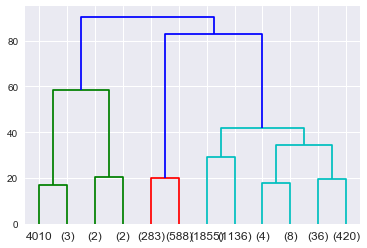

In [19]:
Link = linkage(X_rfm_scaled, 'ward')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

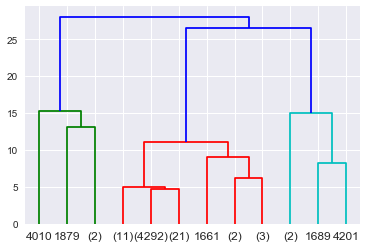

In [20]:
# En utilisant le lien moyen 
Link = linkage(X_rfm_scaled, 'average')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

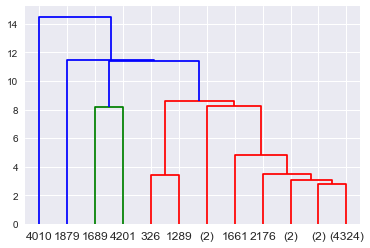

In [21]:
# En utilisant le lien simple
Link = linkage(X_rfm_scaled, 'single')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

# Etude sur le jeu de données RFM

## Agglomerative clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(linkage='ward', n_clusters=3)
model.fit(X_rfm_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x00000123535F28C8>)

Il y a  3  clusters différents


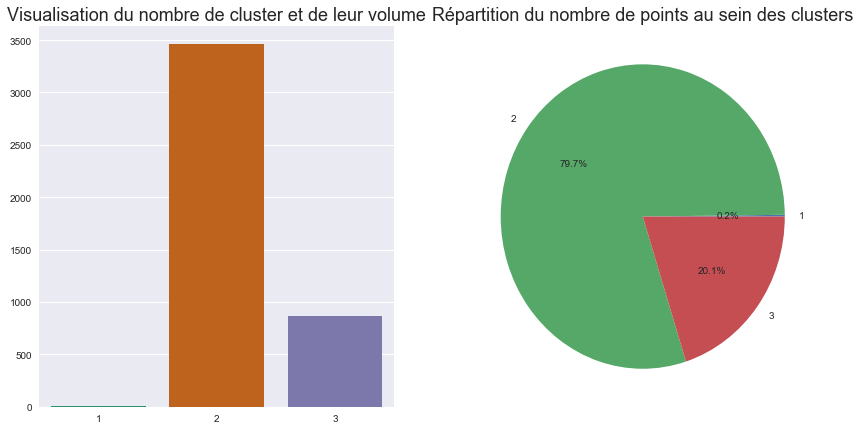

In [23]:
Cluster_Count(model.labels_)

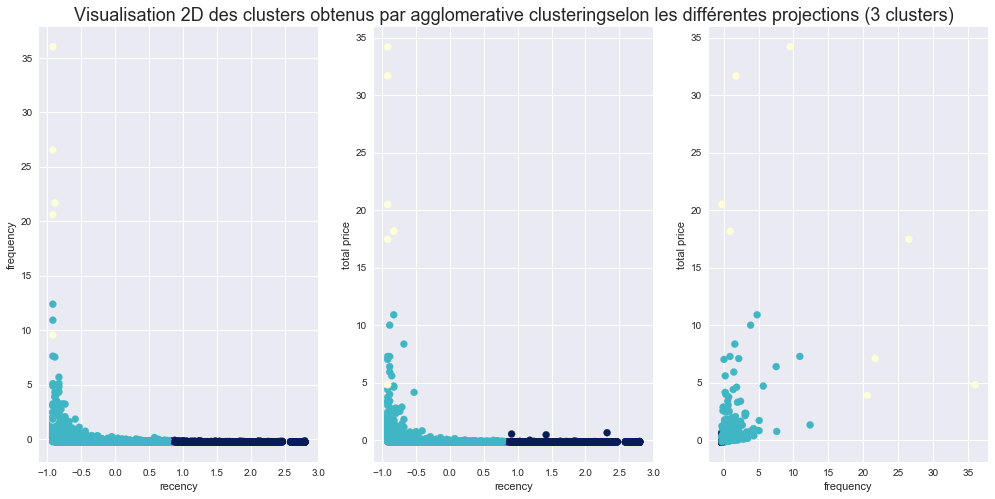

In [24]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(131)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1], c=model.labels_, cmap="YlGnBu")
ax.set_xlabel('recency')
ax.set_ylabel('frequency')

ax = fig.add_subplot(132)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 2], c=model.labels_, cmap="YlGnBu")
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters obtenus par agglomerative clustering'
          'selon les différentes projections (3 clusters)', fontsize=18)

ax = fig.add_subplot(133)
ax.scatter(X_rfm_scaled[:, 1], X_rfm_scaled[:, 2], c=model.labels_, cmap="YlGnBu")
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
knn = KNeighborsClassifier()

KNN = NearestNeighbors(n_neighbors=5)
KNN.fit(X_rfm_scaled)
KNN.kneighbors_graph(X_rfm_scaled)

knn.fit(X_rfm_scaled[:, 1:2], y_rfm)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## K-Means

Il y a  3  clusters différents


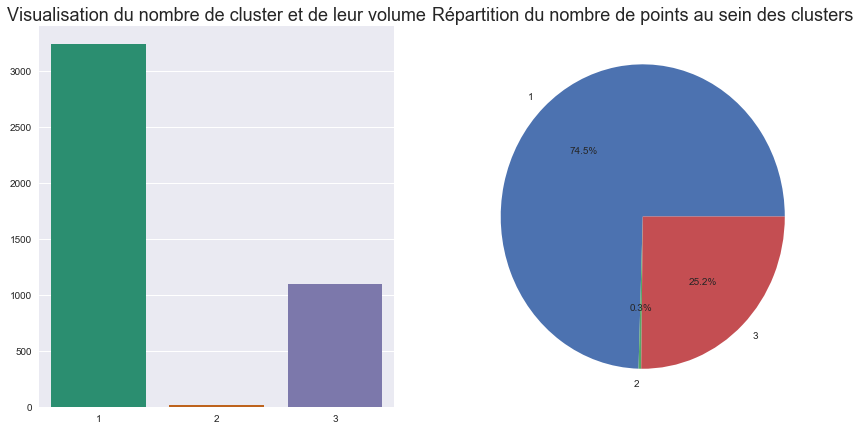

In [26]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_rfm_scaled)
Cluster_Count(kmeans.labels_)

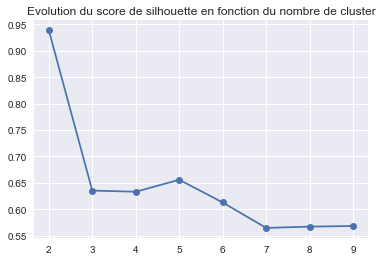

In [27]:
silhouette = []
for num_clusters in range(2, 10):
    cls = KMeans(n_clusters=num_clusters)
    cls.fit(X_rfm_scaled)
    silh = silhouette_score(X_rfm_scaled, cls.labels_)
    silhouette.append(silh)

plt.plot(range(2, 10), silhouette, marker='o')

plt.title('Evolution du score de silhouette en fonction du nombre de cluster')
plt.show()

In [28]:
# 5 a l'air d'etre un bon choix ! 

In [29]:
# Autres méthodes d'évaluation du clustering effectué 

#### Decomposition en 2 composantes principales pour visualisation

In [30]:
from sklearn import decomposition 
pca = decomposition.PCA(n_components=2)
pca.fit(X_rfm_scaled)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_rfm_scaled)

[0.51401104 0.81649503]


In [31]:
print(pca.components_)

[[-0.39417369  0.66417638  0.63521401]
 [ 0.90976976  0.18409089  0.37206119]]


In [32]:
# ACP avec noyau
kpca = decomposition.KernelPCA(n_components=2, kernel='rbf')
kpca.fit(X_rfm_scaled)
#print(kpca.explained_variance_ratio_.cumsum())
print(X_rfm_scaled.shape)
print(kpca.alphas_[:, 0:2])
X_ktrans = kpca.transform(X_rfm_scaled)

(4338, 3)
[[ 0.02588632  0.02169894]
 [-0.01079398  0.02306969]
 [-0.00539077 -0.01469763]
 ...
 [-0.01268988  0.00473616]
 [ 0.00765591  0.02849473]
 [-0.01053321 -0.00406916]]


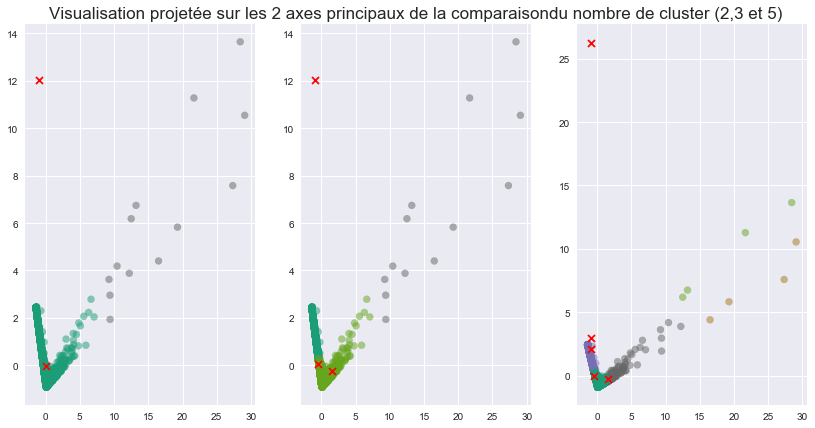

In [33]:
fig = plt.figure(figsize=(14, 7))

cls = KMeans(n_clusters=2)
cls.fit(X_rfm_scaled)
ax = fig.add_subplot(131)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])

cls3 = KMeans(n_clusters=3)
cls3.fit(X_rfm_scaled)
ax = fig.add_subplot(132)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls3.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls3.cluster_centers_[:, 0], cls3.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])
plt.title('Visualisation projetée sur les 2 axes principaux de la comparaison'
          'du nombre de cluster (2,3 et 5)', fontsize=17)

cls5 = KMeans(n_clusters=5)
cls5.fit(X_rfm_scaled)
ax = fig.add_subplot(133)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu",  c=['r'])

plt.show()

[ 0.00270347 -0.03614247 -0.04015963]
[-0.89942483 12.02432336 13.36079863]
Il y a  2  clusters différents


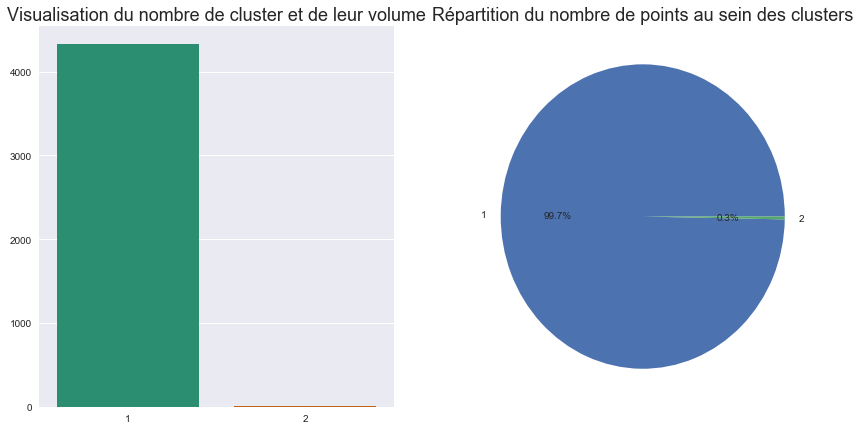

In [34]:
#print(cls.labels_)
print(cls.cluster_centers_[0, :])
print(cls.cluster_centers_[1, :])
Cluster_Count(cls.labels_)

[[ 1.53641932e+00 -2.52117739e-01 -1.56860587e-01]
 [-5.15334791e-01  3.68067948e-02 -7.41918093e-04]
 [-8.99424834e-01  1.20243234e+01  1.33607986e+01]]
Il y a  3  clusters différents


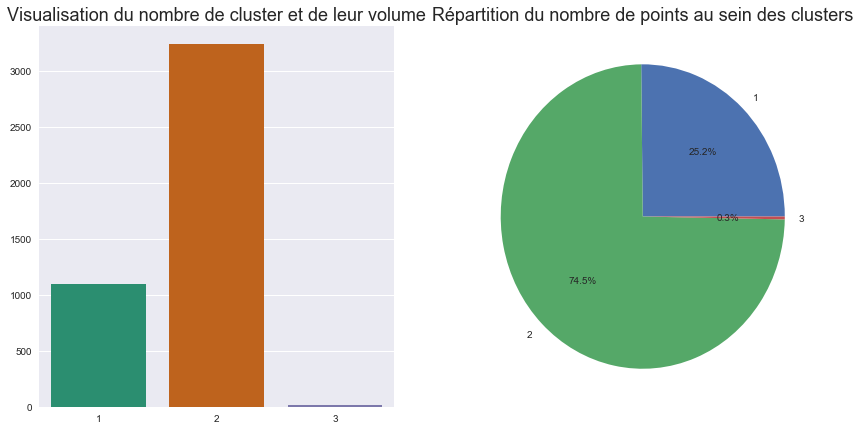

In [35]:
print(cls3.cluster_centers_)
Cluster_Count(cls3.labels_)

[[-0.49106785 -0.04502072 -0.06033585]
 [ 1.56355105 -0.25246698 -0.15694683]
 [-0.89769464  3.00221548 26.14361026]
 [-0.91268969 26.20346486  8.314485  ]
 [-0.86641925  2.08954947  1.55549215]]
Il y a  5  clusters différents


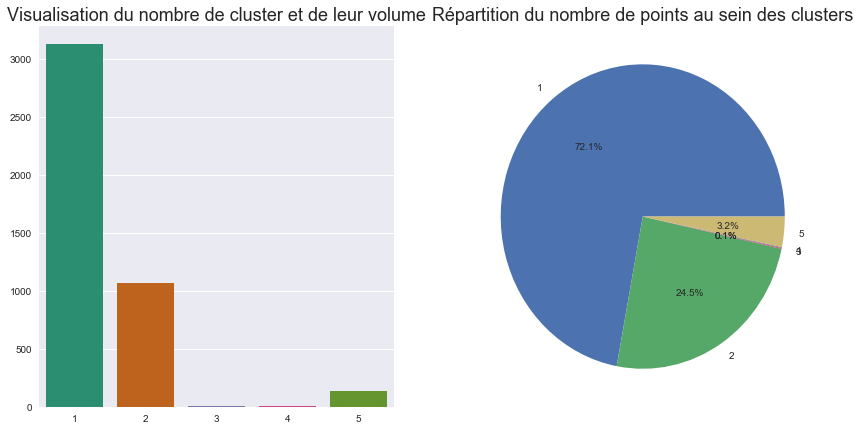

In [36]:
print(cls5.cluster_centers_)
Cluster_Count(cls5.labels_)

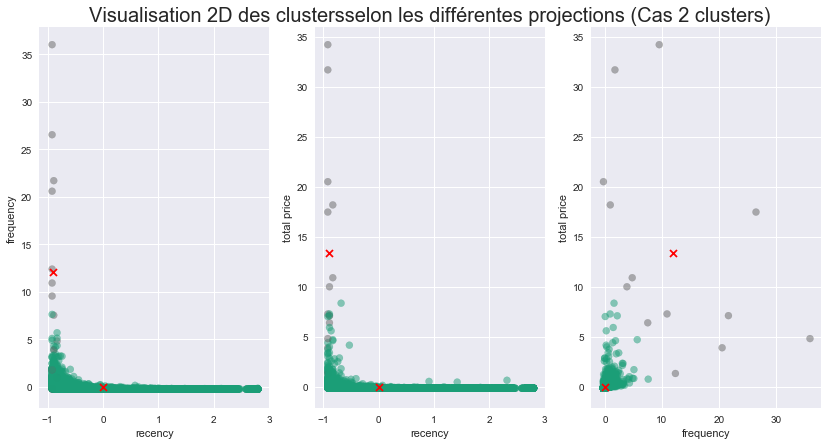

In [37]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')


ax = fig.add_subplot(132)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 2],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters'
          'selon les différentes projections (Cas 2 clusters)', fontsize=20)


ax = fig.add_subplot(133)
ax.scatter(X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 1], cls.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

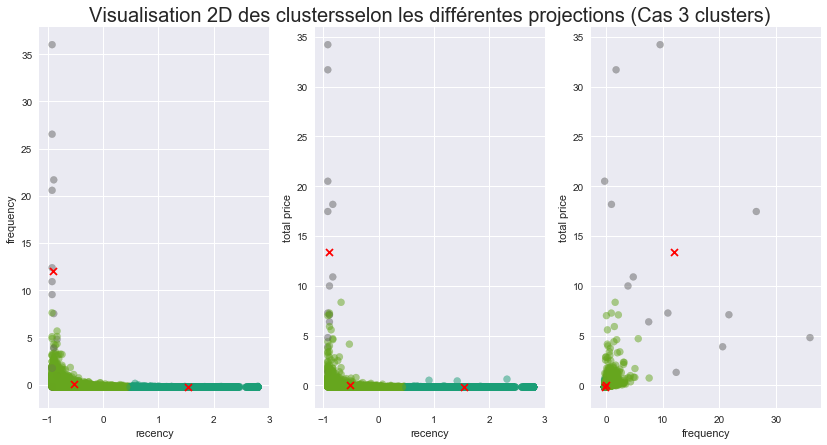

In [38]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1],
           c=cls3.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls3.cluster_centers_[:, 0], cls3.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')


ax = fig.add_subplot(132)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 2],
           c=cls3.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls3.cluster_centers_[:, 0], cls3.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters'
          'selon les différentes projections (Cas 3 clusters)', fontsize=20)


ax = fig.add_subplot(133)
ax.scatter(X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls3.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls3.cluster_centers_[:, 1], cls3.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

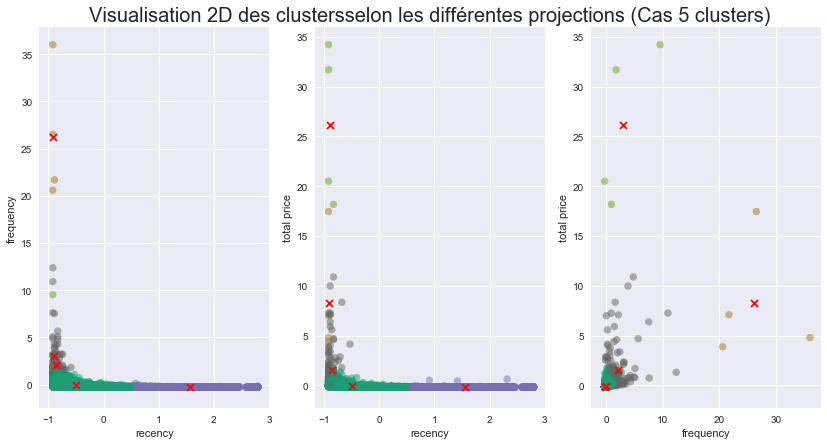

In [39]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')


ax = fig.add_subplot(132)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 2],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters'
          'selon les différentes projections (Cas 5 clusters)', fontsize=20)


ax = fig.add_subplot(133)
ax.scatter(X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 1], cls5.cluster_centers_[:, 2],
           marker='x', cmap="YlGnBu", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

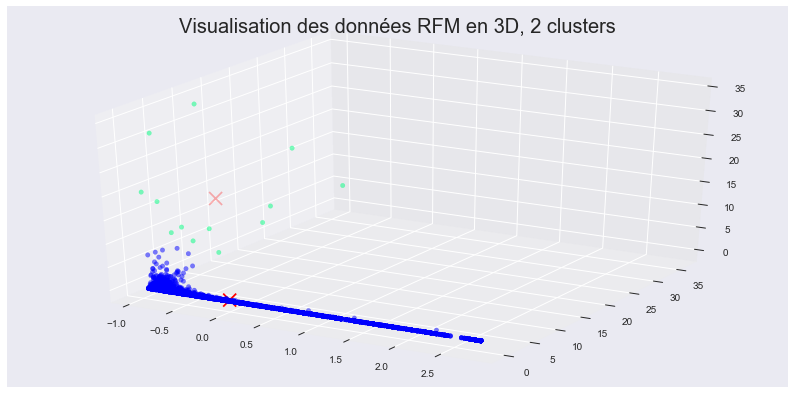

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls.labels_, cmap="winter", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1],
           cls.cluster_centers_[:, 2], marker='x', c=['r'], s=13**2)
plt.title('Visualisation des données RFM en 3D, 2 clusters', fontsize=20)
plt.show()

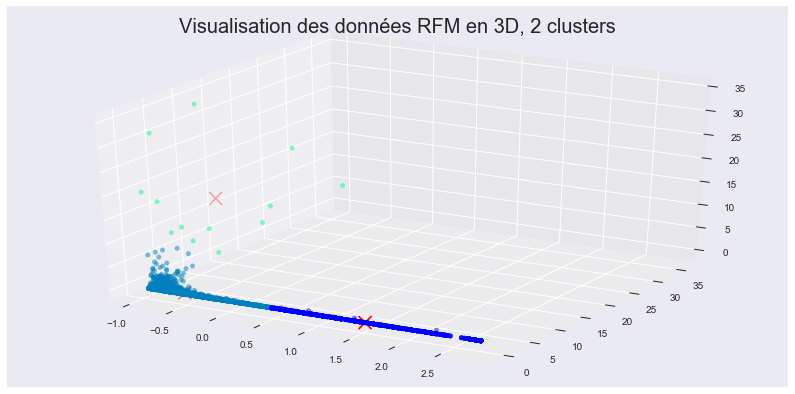

In [41]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls3.labels_, cmap="winter", alpha=alpha)
ax.scatter(cls3.cluster_centers_[:, 0], cls3.cluster_centers_[:, 1],
           cls3.cluster_centers_[:, 2], marker='x', c=['r'], s=13**2)
plt.title('Visualisation des données RFM en 3D, 2 clusters', fontsize=20)
plt.show()

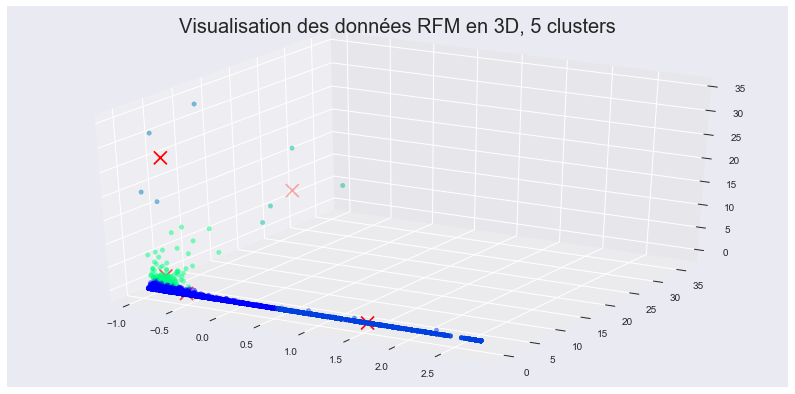

In [42]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=cls5.labels_, cmap="winter", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1],
           cls5.cluster_centers_[:, 2], marker='x', c=['r'], s=13**2)
plt.title('Visualisation des données RFM en 3D, 5 clusters', fontsize=20)
plt.show()

On voit que les meilleurs clients (montant et fréquence)ont tous effectués des achats recemment, les clients dont les achats
sont plus anciens ont en moyenne largemment moins dépensés.

## tSNE

In [43]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=5000, init='pca')
X_tsne = tsne.fit_transform(X_rfm_scaled)

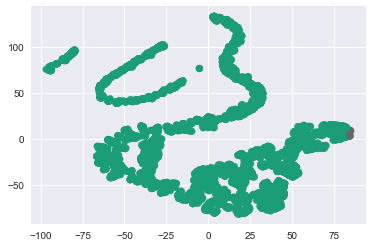

In [44]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cls.labels_, cmap='Dark2')
plt.show()

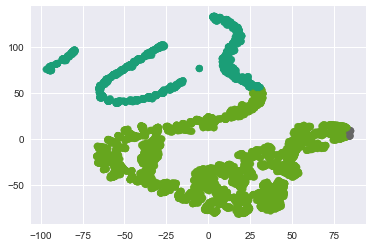

In [45]:
plt.scatter(X_tsne[:, 0],X_tsne[:, 1], c=cls3.labels_, cmap='Dark2')
plt.show()

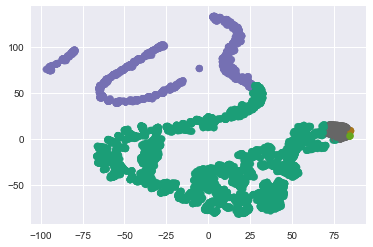

In [46]:
plt.scatter(X_tsne[:, 0],X_tsne[:, 1], c=cls5.labels_, cmap='Dark2')
plt.show()

Cela tend à confirmer la présence de 3 clusters

# DBSCAN

[ 0  0  0 ...  0 -1  0]
Il y a  2  clusters différents


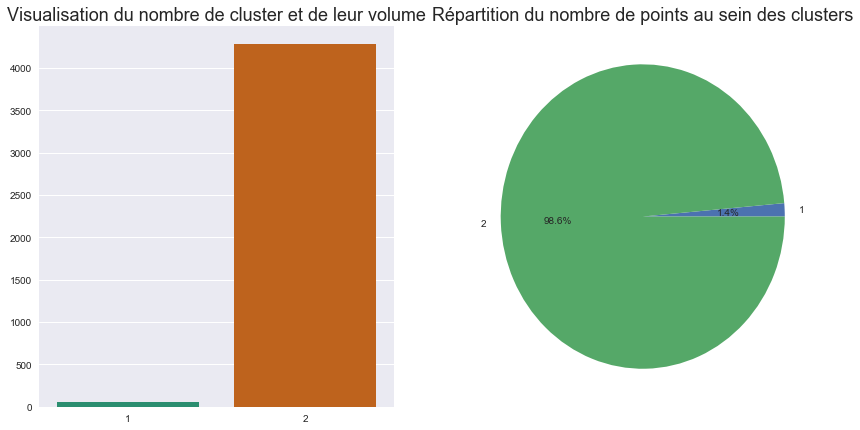

In [47]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(eps=1, min_samples=200)
db.fit(X_rfm_scaled)
print(db.labels_)
Cluster_Count(db.labels_ + 1)

Silhouette Coefficient: 0.835


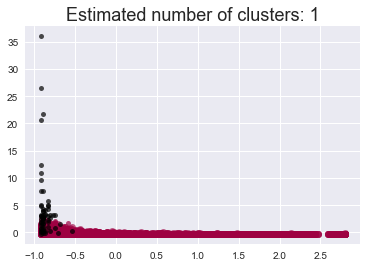

In [48]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Silhouette Coefficient: %0.3f" %
      metrics.silhouette_score(X_rfm_scaled, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_rfm_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7, alpha=0.6)

    xy = X_rfm_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5, alpha=0.7)

plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=18)
plt.show()


Le DBSCAN nous indique qu'il existe un cluster largement majoritaire. Ensuite qu'il y a de nombreux outliers ne pouvant
etre localement liés avec d'autres clients.

In [49]:
# Décomposition du jeu de données
from sklearn.model_selection import train_test_split 

X_rfm_train, X_rfm_test, y_rfm_train, y_rfm_test = train_test_split(X_rfm, y_rfm) 

## MeanShift

Il y a  29  clusters différents


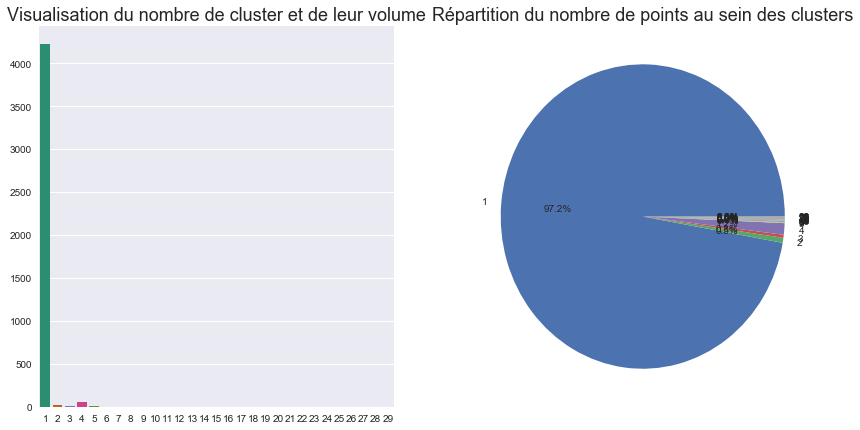

In [50]:
from sklearn.cluster import MeanShift
MS = MeanShift()
MS.fit(X_rfm_scaled)
Cluster_Count(MS.labels_)

In [51]:
MS.labels_.max()

28

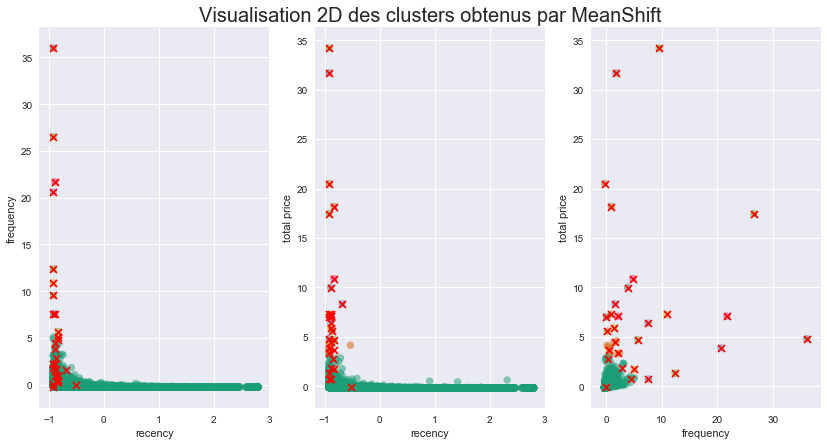

In [52]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 1],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 0], MS.cluster_centers_[:, 1],
           marker='x', c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')

ax = fig.add_subplot(132)
ax.scatter(X_rfm_scaled[:, 0], X_rfm_scaled[:, 2],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 0], MS.cluster_centers_[:, 2],
           marker='x', c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters obtenus par MeanShift', fontsize=20)

ax = fig.add_subplot(133)
ax.scatter(X_rfm_scaled[:, 1], X_rfm_scaled[:, 2],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 1], MS.cluster_centers_[:, 2],
           marker='x', c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

# Etude sur le jeu de données rfm + nouvelles features

In [53]:
scaler2 = preprocessing.StandardScaler()
scaler2.fit(X_data)
X_data_sc = scaler2.transform(X_data)
X_data.columns

Index(['frequency', 'monetary_value', 'Mean Quantity', 'Mean UnitPrice'], dtype='object')

### Hierarichal clustering

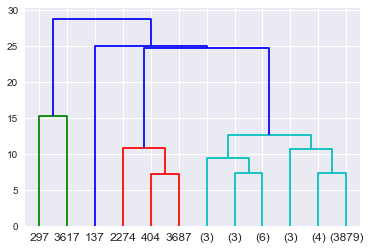

In [54]:
# En utilisant le lien moyen
Link = linkage(X_data_sc, 'average')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

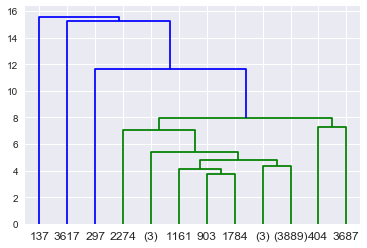

In [55]:
# En utilisant le lien simple
Link = linkage(X_data_sc, 'single')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

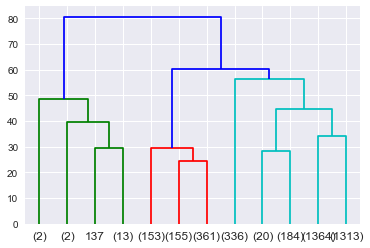

In [56]:
# En utilisant la méthode de ward
Link = linkage(X_data_sc, 'ward')
dn = dendrogram(Link, p=12, truncate_mode='lastp')

Les deux premières méthodes tendent à choisir un nombre de 4 clusters, la méthode de ward pousse à choisir 3 clusters

## Agglomerative Clustering

Il y a  3  clusters différents


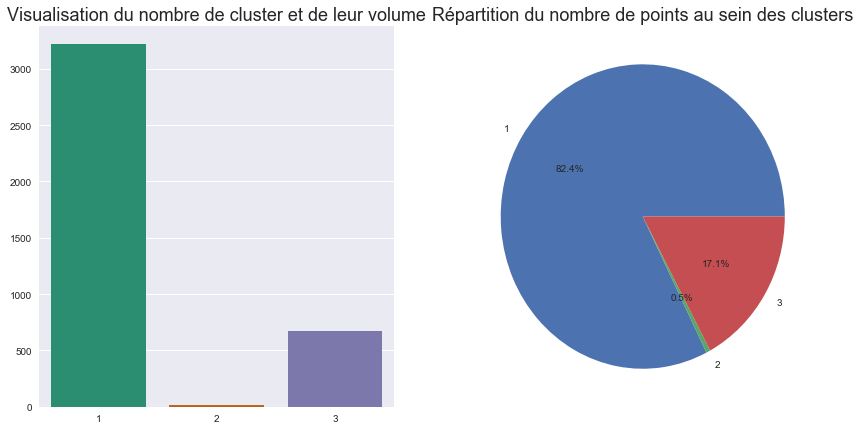

Silhouette Coefficient: 0.357


In [57]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage='ward', n_clusters=3)
model.fit(X_data_sc)
Cluster_Count(model.labels_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_sc, model.labels_))

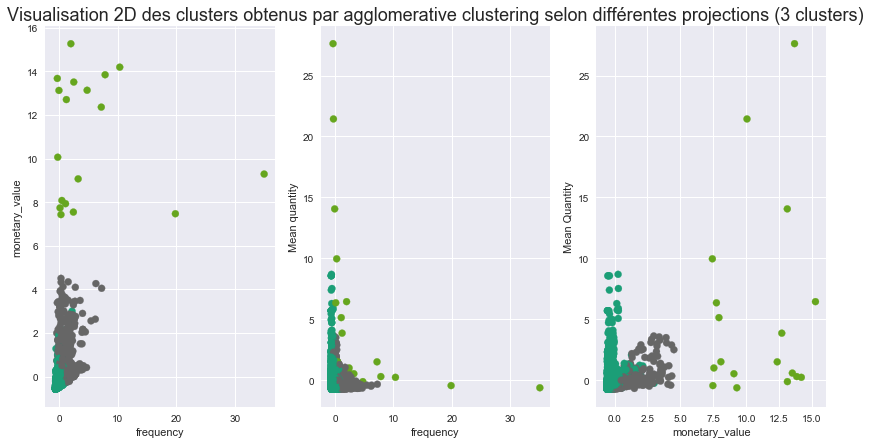

In [58]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=model.labels_, cmap="Dark2")
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')

ax = fig.add_subplot(132)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 2], c=model.labels_, cmap="Dark2")
ax.set_xlabel('frequency')
ax.set_ylabel('Mean quantity')
plt.title('Visualisation 2D des clusters obtenus par agglomerative'
          ' clustering selon différentes projections (3 clusters)',
          fontsize=18)

ax = fig.add_subplot(133)
ax.scatter(X_data_sc[:, 1], X_data_sc[:, 2], c=model.labels_, cmap="Dark2")
ax.set_xlabel('monetary_value')
ax.set_ylabel('Mean Quantity')

plt.show()

### KNN 

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
knn = KNeighborsClassifier()

KNN = NearestNeighbors(n_neighbors=5)
KNN.fit(X_data_sc)
KNN.kneighbors_graph(X_data_sc)

knn.fit(X_data_sc[:, 1:2], y_data)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## K-means

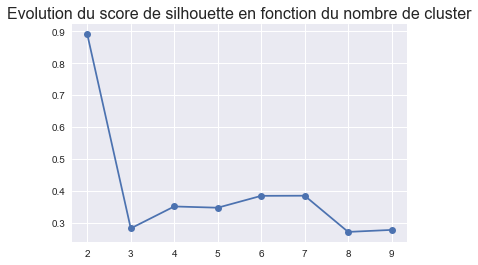

In [60]:
silhouette = []
for num_clusters in range(2, 10):
    cls = KMeans(n_clusters=num_clusters)
    cls.fit(X_data_sc)
    silh = silhouette_score(X_data_sc, cls.labels_)
    silhouette.append(silh)

plt.plot(range(2, 10), silhouette, marker='o')

plt.title('Evolution du score de silhouette en fonction du nombre de cluster',
          fontsize=16)
plt.show()

Il y a  5  clusters différents


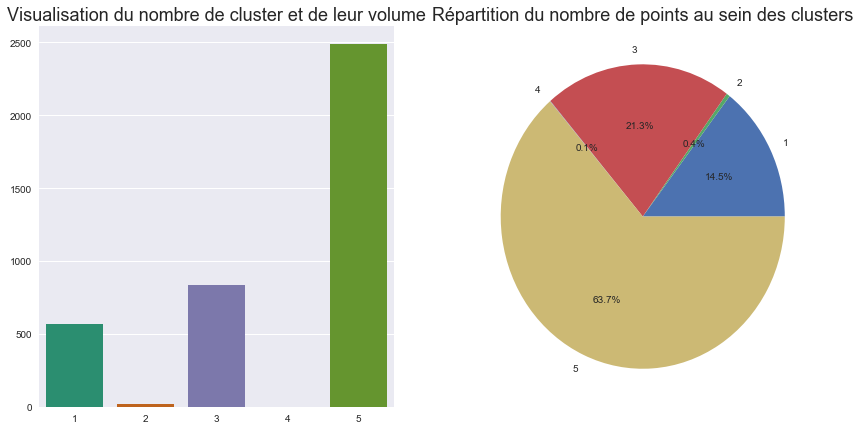

In [61]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_data_sc)
Cluster_Count(kmeans.labels_)

### Décomposition en 2 composantes principales pour visualisation

In [62]:
from sklearn import decomposition 
pca = decomposition.PCA(n_components=3)
pca.fit(X_data_sc)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_data_sc)

[0.40747302 0.68982314 0.93817253]


3


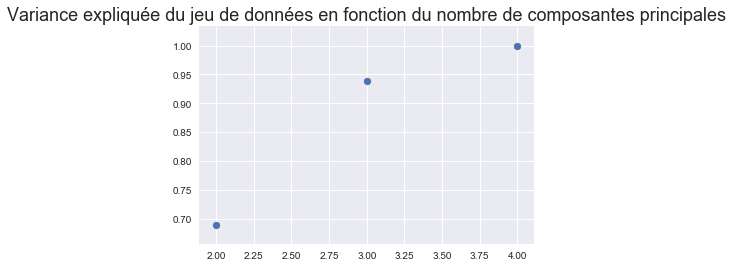

In [63]:
Var = []
Var2 = []
for i in range(2, 5):
    new_pca = decomposition.PCA(n_components=i)
    new_pca.fit(X_data_sc)
    Var.append(new_pca.explained_variance_ratio_.sum())

for i in range(2, 5):
    new_pca = decomposition.PCA(n_components=i)
    new_pca.fit(X_data_sc)
    Var2.append(new_pca.explained_variance_ratio_[i-2])

print(len(Var))
plt.scatter(y=Var, x=[2, 3, 4])
plt.title('Variance expliquée du jeu de données en '
          'fonction du nombre de composantes principales', fontsize=18)
plt.show()

In [64]:
# Essai avec une ACP avec noyau
kpca = decomposition.KernelPCA(n_components=2, kernel='rbf')
kpca.fit(X_data_sc)
print(X_data_sc.shape)
print(kpca.alphas_[:, 0:2])
X_ktrans = kpca.transform(X_data_sc)

(3904, 4)
[[ 0.00948344 -0.01112797]
 [-0.0093423  -0.0217403 ]
 [-0.00937038 -0.02186333]
 ...
 [-0.03478987  0.00587804]
 [-0.03197245  0.01038999]
 [ 0.01982518 -0.012217  ]]


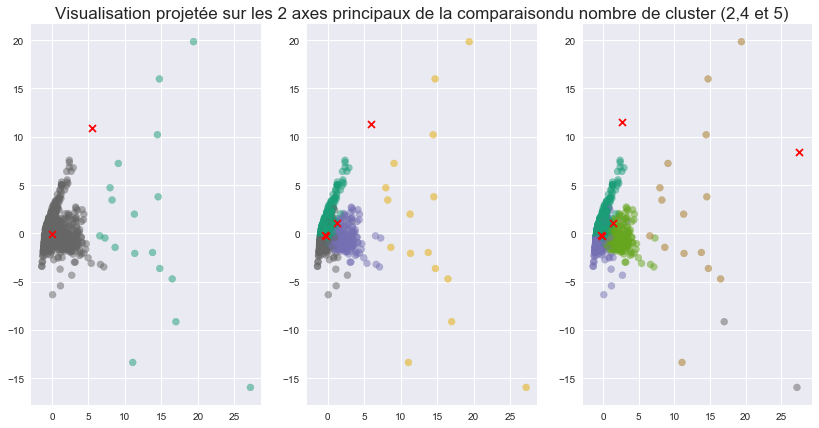

In [65]:
fig = plt.figure(figsize=(14, 7))

cls = KMeans(n_clusters=2)
cls.fit(X_data_sc)
ax = fig.add_subplot(131)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])

cls4 = KMeans(n_clusters=4)
cls4.fit(X_data_sc)
ax = fig.add_subplot(132)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu", c=['r'])
plt.title('Visualisation projetée sur les 2 axes principaux de la comparaison'
          'du nombre de cluster (2,4 et 5)', fontsize=17)

cls5 = KMeans(n_clusters=5)
cls5.fit(X_data_sc)
ax = fig.add_subplot(133)
ax.scatter(X_trans[:, 0], X_trans[:, 1],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1],
           marker='x', cmap="YlGnBu",  c=['r'])

plt.show()

Silhouette Coefficient: 0.891


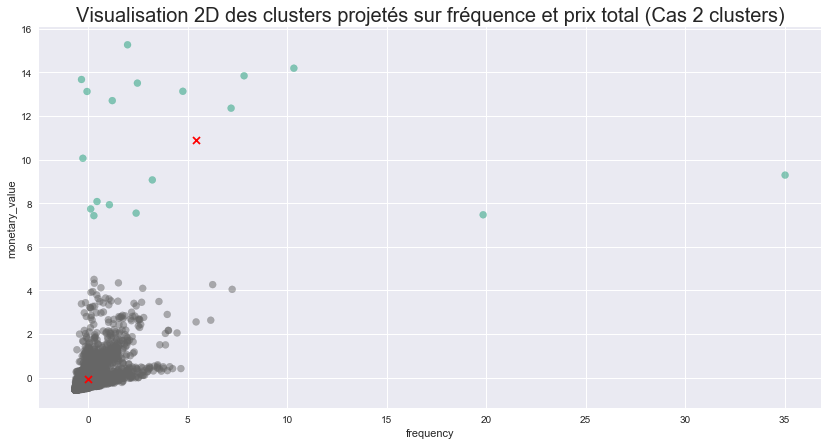

In [66]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_sc, cls.labels_))
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(111)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=cls.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
plt.title('Visualisation 2D des clusters projetés sur fréquence et prix total '
          '(Cas 2 clusters)', fontsize=20)
plt.show()

[ 5.42479802 10.91265128  5.52927916  0.87718709]
[-0.02512773 -0.05054754 -0.02561169 -0.00406314]
Il y a  2  clusters différents


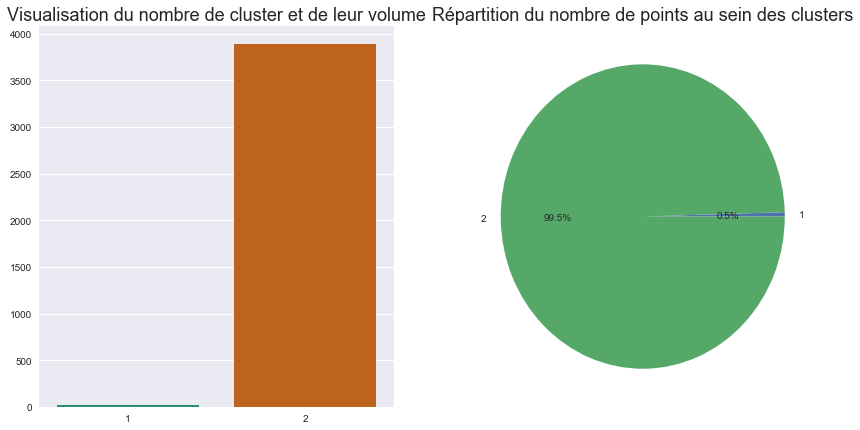

In [67]:
print(cls.cluster_centers_[0, :])
print(cls.cluster_centers_[1, :])
Cluster_Count(cls.labels_)

[[-0.21242151 -0.23170098  0.04569109 -0.41643937]
 [ 1.30961338  1.04801973 -0.05766868 -0.21396514]
 [ 5.92376631 11.30015997  6.06172534  0.90196064]
 [-0.33879441 -0.21920315 -0.19937458  1.26621472]]
Il y a  4  clusters différents


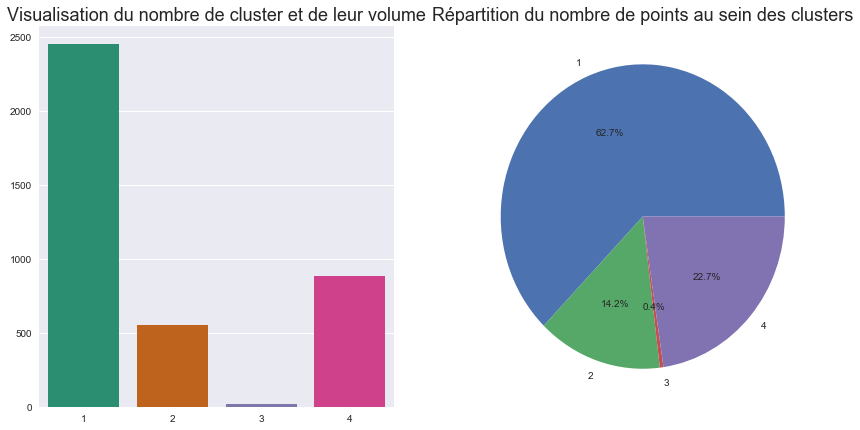

In [68]:
print(cls4.cluster_centers_)
Cluster_Count(cls4.labels_)

Silhouette Coefficient: 0.346


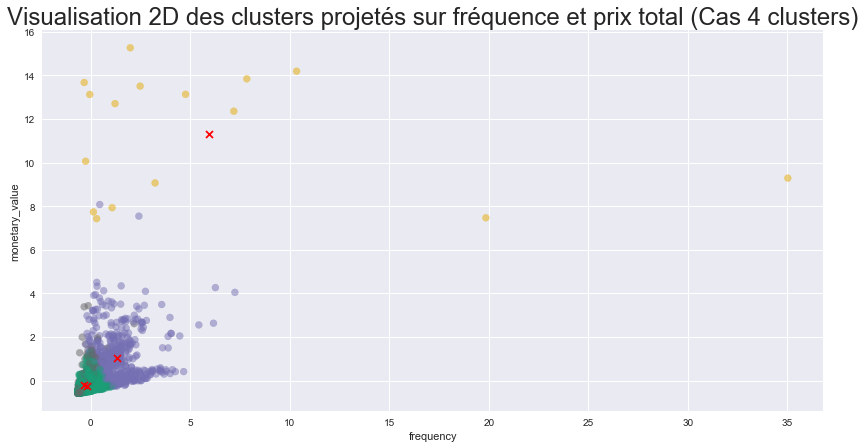

In [69]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_sc, cls4.labels_))
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(111)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 1],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
plt.title('Visualisation 2D des clusters projetés sur fréquence et prix total '
          '(Cas 4 clusters)', fontsize=24)
plt.show()

In [70]:
# sns.barplot(cls4.cluster_centers_[0, :], cls4.cluster_centers_[1, :])
# Il faut tenter de représenter les centres des clusters sur un bar plot, avec en X les différentes variables
# différenciées selon les différents clusters
# En Y une echelle adaptée
print(cls4.cluster_centers_)


[[-0.21242151 -0.23170098  0.04569109 -0.41643937]
 [ 1.30961338  1.04801973 -0.05766868 -0.21396514]
 [ 5.92376631 11.30015997  6.06172534  0.90196064]
 [-0.33879441 -0.21920315 -0.19937458  1.26621472]]


Silhouette Coefficient: 0.346


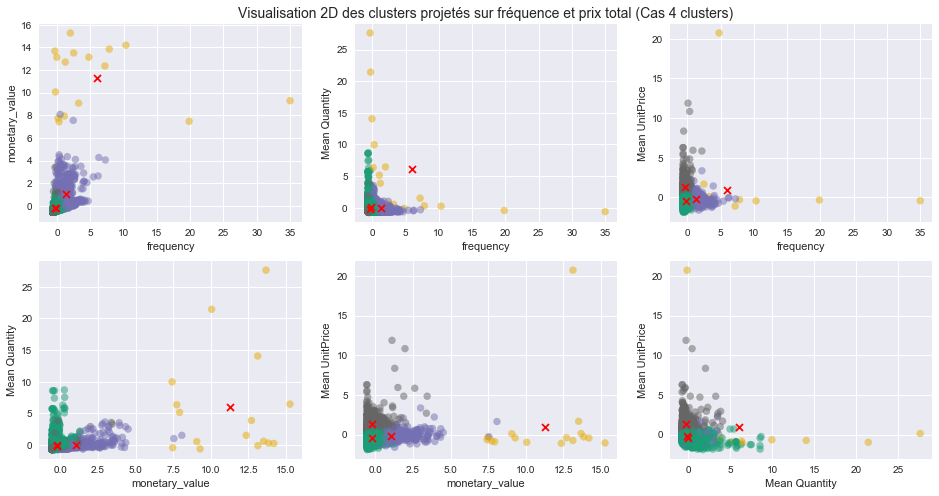

In [102]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_sc, cls4.labels_))
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(231)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 1],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')

ax = fig.add_subplot(232)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 2],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 2],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('Mean Quantity')
plt.title('Visualisation 2D des clusters projetés sur fréquence et prix total '
          '(Cas 4 clusters)', fontsize=14)

ax = fig.add_subplot(233)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 3],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 3],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('Mean UnitPrice')

ax = fig.add_subplot(234)
ax.scatter(X_data_sc[:, 1], X_data_sc[:, 2],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 1], cls4.cluster_centers_[:, 2],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('monetary_value')
ax.set_ylabel('Mean Quantity')

ax = fig.add_subplot(235)
ax.scatter(X_data_sc[:, 1], X_data_sc[:, 3],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 1], cls4.cluster_centers_[:, 3],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('monetary_value')
ax.set_ylabel('Mean UnitPrice')

ax = fig.add_subplot(236)
ax.scatter(X_data_sc[:, 2], X_data_sc[:, 3],
           c=cls4.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls4.cluster_centers_[:, 2], cls4.cluster_centers_[:, 3],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('Mean Quantity')
ax.set_ylabel('Mean UnitPrice')

plt.show()

In [104]:
data['cluster'] = cls4.labels_

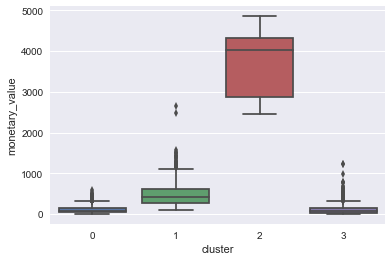

In [106]:
sns.boxplot(x=data['cluster'], y=data['monetary_value'])

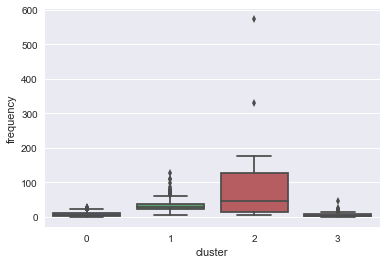

In [107]:
sns.boxplot(x=data['cluster'], y=data['frequency'])

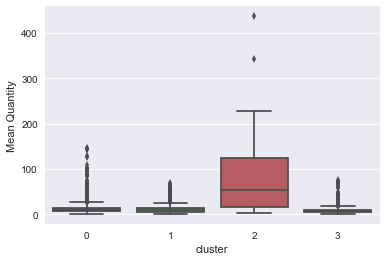

In [108]:
sns.boxplot(x=data['cluster'], y=data['Mean Quantity'])

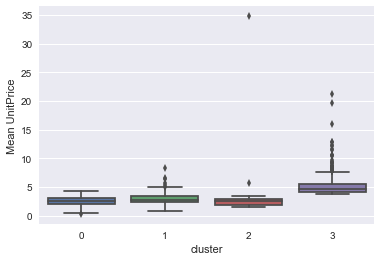

In [109]:
sns.boxplot(x=data['cluster'], y=data['Mean UnitPrice'])

[[-0.21299736 -0.23202407  0.04558438 -0.41596502]
 [-0.33992123 -0.21873138 -0.19854416  1.26918104]
 [ 1.30932879  1.03148153 -0.06232343 -0.2157576 ]
 [ 2.69027513 11.4746698   6.63672658  1.12275297]
 [27.43815491  8.38057751 -0.51945914 -0.3847476 ]]
Il y a  5  clusters différents


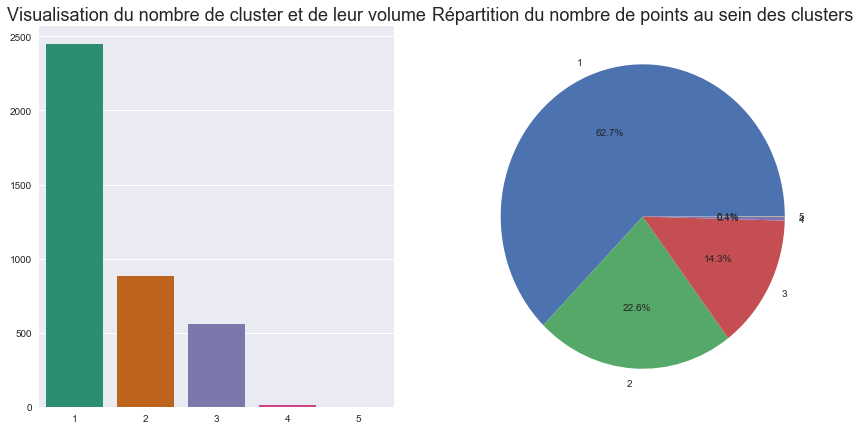

In [71]:
print(cls5.cluster_centers_)
Cluster_Count(cls5.labels_)

Silhouette Coefficient: 0.347


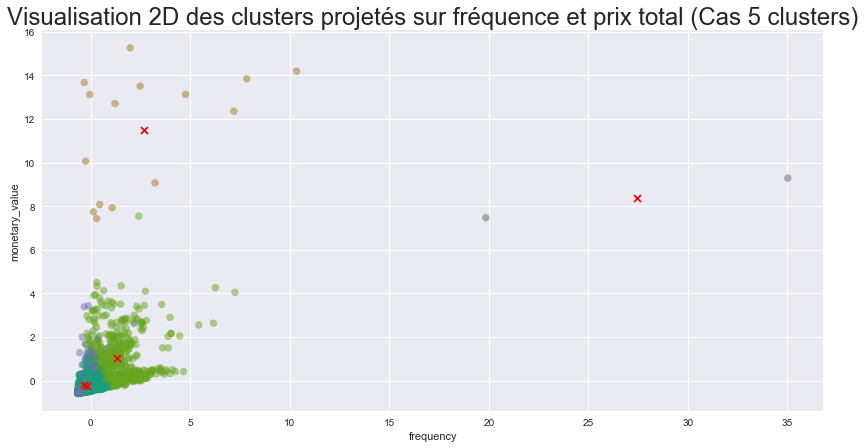

In [72]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_sc, cls5.labels_))
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(111)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=cls5.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1],
           marker='x', c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
plt.title('Visualisation 2D des clusters projetés sur fréquence et prix total '
          '(Cas 5 clusters)', fontsize=24)
plt.show()

Il y a  7  clusters différents


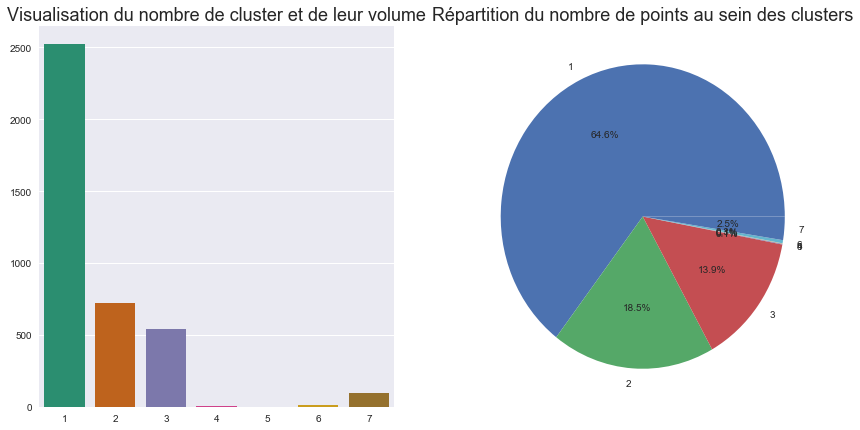

In [100]:
cls8 = KMeans(n_clusters=7)
cls8.fit(X_data_sc)
Cluster_Count(cls8.labels_)

# tSNE

In [73]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=5000, init='pca')
X_tSNE = tsne.fit_transform(X_data_sc)

In [74]:
tsne2 = manifold.TSNE(n_components=2, perplexity=50, n_iter=5000, init='pca')
X_tSNE2 = tsne2.fit_transform(X_data_sc)

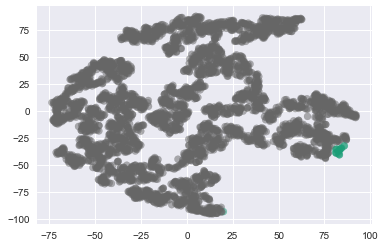

In [75]:
plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=cls.labels_, cmap='Dark2', alpha=alpha)
plt.show()

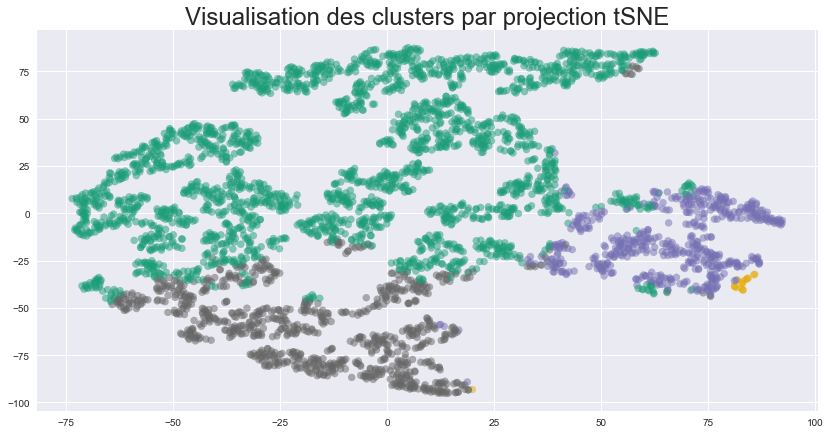

In [95]:
fig = plt.figure(figsize=(14, 7))
plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=cls4.labels_, cmap='Dark2', alpha=alpha)
plt.title('Visualisation des clusters par projection tSNE', fontsize = 24)
plt.show()

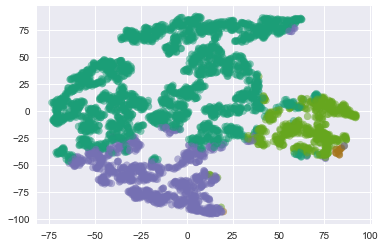

In [77]:
plt.scatter(X_tSNE[:, 0], X_tSNE[:, 1], c=cls5.labels_, cmap='Dark2', alpha=alpha)
plt.show()

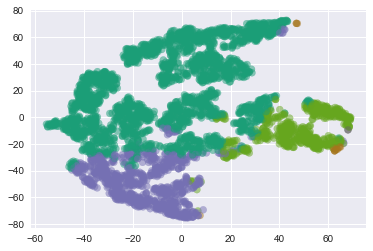

In [78]:
plt.scatter(X_tSNE2[:, 0], X_tSNE2[:, 1], c=cls5.labels_, cmap='Dark2', alpha=alpha)
plt.show()

## DBSCAN

[1 0 0 ... 1 1 1]
Il y a  2  clusters différents


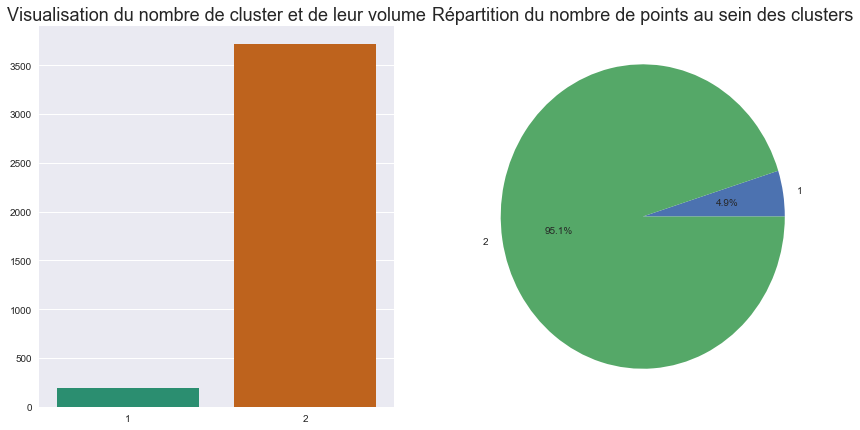

In [110]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(eps=1, min_samples=10)
db.fit(X_data_sc)
print(db.labels_ + 1)
Cluster_Count(db.labels_ + 1)

Silhouette Coefficient: 0.656


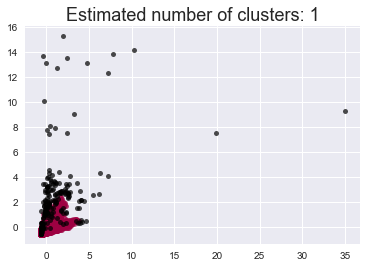

In [80]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      
print("Silhouette Coefficient: %0.3f" % 
      metrics.silhouette_score(X_data_sc, labels))


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_data_sc[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7, alpha=0.6)

    xy = X_data_sc[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5, alpha=0.7)

plt.title('Estimated number of clusters: %d' % n_clusters_, fontsize=18)
plt.show()


## MeanShift

Il y a  39  clusters différents


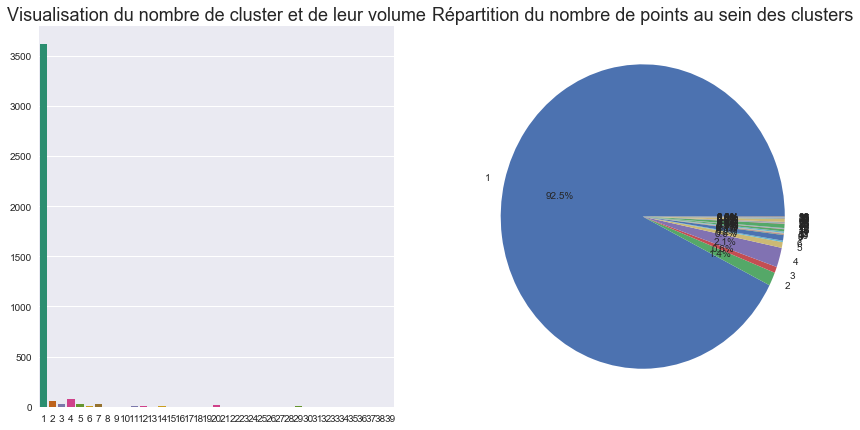

In [81]:
MS = MeanShift()
MS.fit(X_data_sc)
Cluster_Count(MS.labels_)

In [82]:
MS.labels_.max()

38

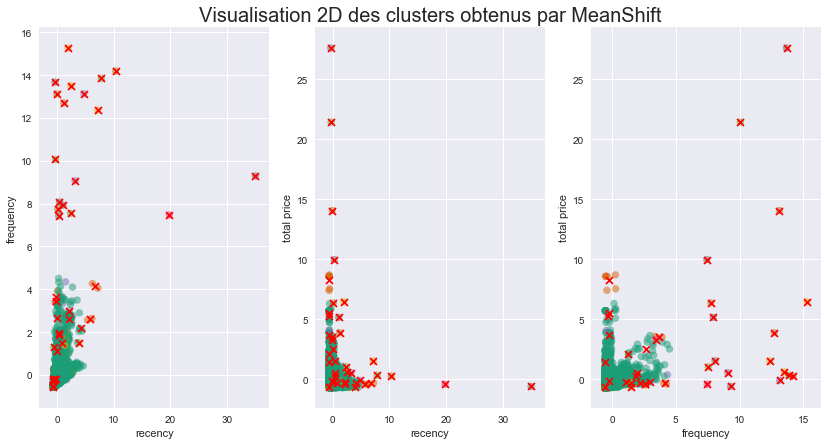

In [83]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(131)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 1],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 0], MS.cluster_centers_[:, 1],
           marker='x', c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('frequency')

ax = fig.add_subplot(132)
ax.scatter(X_data_sc[:, 0], X_data_sc[:, 2],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 0], MS.cluster_centers_[:, 2],
           marker='x', c=['r'])
ax.set_xlabel('recency')
ax.set_ylabel('total price')
plt.title('Visualisation 2D des clusters obtenus par MeanShift', fontsize=20)

ax = fig.add_subplot(133)
ax.scatter(X_data_sc[:, 1], X_data_sc[:, 2],
           c=MS.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(MS.cluster_centers_[:, 1], MS.cluster_centers_[:, 2],
           marker='x', c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('total price')

plt.show()

In [84]:
# Décomposition du jeu de données
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data) 

In [85]:
# labels = kmeans_model.labels_
# metrics.calinski_harabaz_score(X, labels)

# Etude de la stabilité temporelle 

In [86]:
data_SH = pd.read_csv('data_SH.csv')
data_FH = pd.read_csv('data_FH.csv')
X_data_FH = data_FH.drop(['CustomerID'], axis=1)
X_data_SH = data_SH.drop(['CustomerID'], axis=1)

In [87]:
X_data_FH.describe()

frequency  monetary_value  Mean_Quantity  Mean_UnitPrice
count  2833.000000     2833.000000    2833.000000     2833.000000
mean      5.014118       86.883269      12.012535        3.325092
std       5.363128      106.234545      12.352511        1.596703
min       0.074627        0.855072       1.000000        0.386667
25%       1.515152       25.371930       5.818182        2.322955
50%       3.278689       50.879487       9.472727        3.046154
75%       6.666667      104.233628      13.402439        4.009167
max      60.285714      747.468182     127.333333       31.447213

In [88]:
X_data_SH.describe()

frequency  monetary_value  Mean_Quantity  Mean_UnitPrice
count  3904.000000     3904.000000    3904.000000     3904.000000
mean     10.522379      179.042060      12.329606        3.190293
std      16.057159      306.249656      15.357430        1.523292
min       0.074627        2.000000       1.000000        0.290000
25%       2.641509       45.227068       6.076211        2.254235
50%       6.416502       99.837976       9.756521        2.939317
75%      13.125000      203.762435      13.597581        3.779501
max     572.835821     4853.702985     436.371429       34.754521

In [89]:
scaler3 = preprocessing.StandardScaler()
scaler3.fit(X_data_FH)
X_data_FH = scaler3.transform(X_data_FH)

scaler4 = preprocessing.StandardScaler()
scaler4.fit(X_data_SH)
X_data_SH = scaler4.transform(X_data_SH)

Silhouette Coefficient: 0.327
Il y a  4  clusters différents


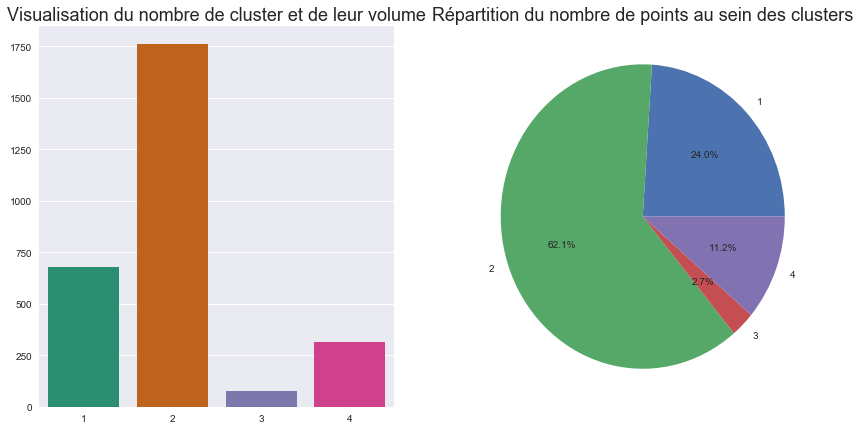

In [90]:
kmeans_1 = KMeans(n_clusters=4)
kmeans_1.fit(X_data_FH)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_FH, kmeans_1.labels_))
Cluster_Count(kmeans_1.labels_)

Silhouette Coefficient: 0.347
Il y a  4  clusters différents


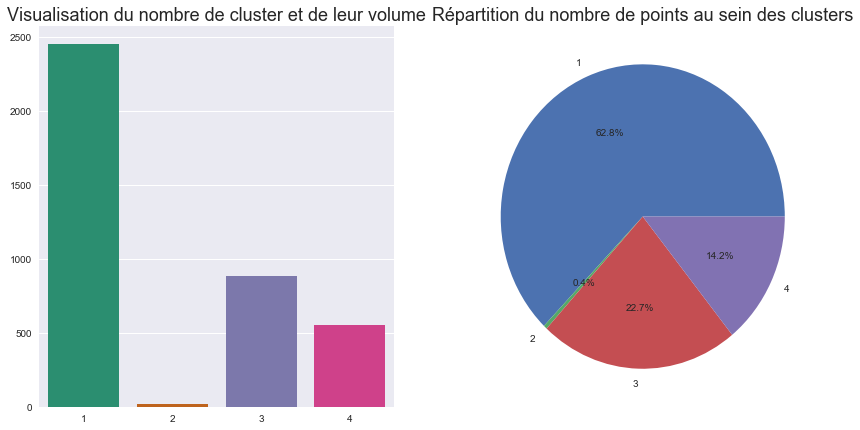

In [91]:
kmeans_2 = KMeans(n_clusters=4)
kmeans_2.fit(X_data_SH)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_data_SH, kmeans_2.labels_))
Cluster_Count(kmeans_2.labels_)

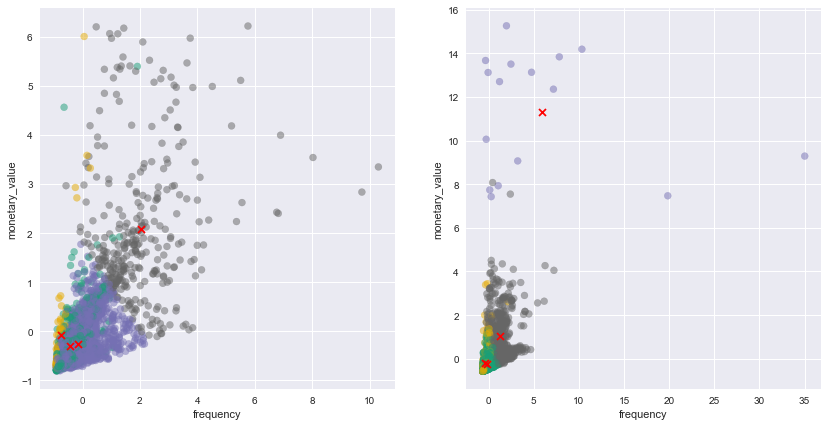

In [92]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(121)
ax.scatter(X_data_FH[:, 0], X_data_FH[:, 1],
           c=kmeans_1.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(kmeans_1.cluster_centers_[:, 0], kmeans_1.cluster_centers_[:, 1],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')

ax = fig.add_subplot(122)
ax.scatter(X_data_SH[:, 0], X_data_SH[:, 1],
           c=kmeans_2.labels_, cmap="Dark2", alpha=alpha)
ax.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1],
           marker='x', cmap="Dark2", c=['r'])
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')


plt.show()